In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
sys.path.append('C:\\Program Files\\lib\\site-packages')
import tensorflow as tf
import keras

Using TensorFlow backend.


In [3]:
os.chdir('C://Users//nschm/economic_data/')
cpi_data=pd.read_csv('CPIAUCSL.csv')
unemp=pd.read_csv('Unemploy_rate.csv')
cpi_data['pd_date']=pd.to_datetime(cpi_data['DATE'])
unemp['pd_date']=pd.to_datetime(unemp['DATE'])

In [4]:
def date_align(dfA, datatitleA, dfB, datatitleB):
    i = 0
    j = 0
    new_df = pd.DataFrame()
    date_list = []
    A_list = []
    B_list = []
    while i < len(dfA['pd_date']) and j < len(dfB['pd_date']):
        if dfA['pd_date'][i] < dfB['pd_date'][j]:
            date_list.append(dfA['pd_date'][i])
            A_list.append(dfA[datatitleA][i])
            B_list.append(np.nan)
            i += 1
        elif dfA['pd_date'][i] == dfB['pd_date'][j]:
            date_list.append(dfA['pd_date'][i])
            A_list.append(dfA[datatitleA][i])
            B_list.append(dfB[datatitleB][j])
            i += 1
            j += 1
        elif dfA['pd_date'][i] > dfB['pd_date'][j]:
            date_list.append(dfB['pd_date'][j])
            A_list.append(np.nan)
            B_list.append(dfB[datatitleB][j])
            j += 1
    while j < len(dfB['pd_date']):
        date_list.append(dfB['pd_date'][j])
        A_list.append(np.nan)
        B_list.append(dfB[datatitleB][j])
        j += 1
    while i < len(dfA['pd_date']):
        date_list.append(dfA['pd_date'][i])
        A_list.append(dfA[datatitleA][i])
        B_list.append(np.nan)
        i += 1
    new_df['pd_date'] = date_list
    new_df[datatitleA] = A_list
    new_df[datatitleB] = B_list
    return new_df

def create_diff_vector(start_df, datatitle, datetitle):
    diff = []
    diff_perc = []
    diff.append(np.nan)
    diff_perc.append(np.nan)
    for i in range(1, len(start_df[datetitle])):
        diff.append(start_df[datatitle][i] - start_df[datatitle][i - 1])
        diff_perc.append((start_df[datatitle][i] - start_df[datatitle][i - 1]) / start_df[datatitle][i])
    return diff, diff_perc

def remove_rows(df, num_rows):
    df=df.drop(df.index[0:num_rows])
    df=df.reset_index()
    df=df.drop(['index'], axis=1)
    return df

In [5]:
cpi_data=pd.read_csv('CPIAUCSL.csv')
unemp=pd.read_csv('Unemploy_rate.csv')
cpi_data['pd_date']=pd.to_datetime(cpi_data['DATE'])
unemp['pd_date']=pd.to_datetime(unemp['DATE'])

In [6]:
ppi_data=pd.read_csv('PPIACO.csv')
ppi_data['pd_date']=pd.to_datetime(ppi_data['DATE'])
ppi_data=remove_rows(ppi_data, 408)

In [7]:
combined_df = date_align(cpi_data, 'CPIAUCSL', unemp, 'UNRATE')
[cpi_diff, cpi_diff_perc]=create_diff_vector(combined_df, 'CPIAUCSL', 'pd_date')
[unemp_diff, unemp_diff_perc]=create_diff_vector(combined_df, 'UNRATE', 'pd_date')
combined_df['cpi_diff']=cpi_diff
combined_df['cpi_diff_perc']=cpi_diff_perc
combined_df['unemp_diff']=unemp_diff
combined_df['unemp_diff_perc']=unemp_diff_perc

In [8]:
temp_combined_df = date_align(cpi_data, 'CPIAUCSL', ppi_data, 'PPIACO')
combined_df['PPI']=temp_combined_df['PPIACO']
[ppi_diff, ppi_diff_perc]=create_diff_vector(combined_df, 'PPI', 'pd_date')
combined_df['ppi_diff']=ppi_diff
combined_df['ppi_diff_perc']=ppi_diff_perc

In [52]:
combined_df.tail()

,pd_date,CPIAUCSL,UNRATE,cpi_diff,cpi_diff_perc,unemp_diff,unemp_diff_perc,PPI,ppi_diff,ppi_diff_perc
847,2017-08-01,245.030,4.4,0.982,0.004008,0.982,0.004008,193.8,0.3,0.001548
848,2017-09-01,246.373,4.2,1.343,0.005451,1.343,0.005451,194.5,0.7,0.003599
849,2017-10-01,246.639,4.1,0.266,0.001078,0.266,0.001078,194.8,0.3,0.001540
850,2017-11-01,247.592,4.1,0.953,0.003849,0.953,0.003849,195.8,1.0,0.005107
851,2017-12-01,247.963,4.1,0.371,0.001496,0.371,0.001496,196.4,0.6,0.003055


In [53]:
prev_cpi=[]
prev_ppi=[]
prev_unemp=[]
current_cpi=[]
current_ppi=[]
current_unemp=[]
cpi_mean=[]
ppi_mean=[]
unemp_mean=[]
for i in range(150, len(combined_df['pd_date'])):
    prev_cpi.append(combined_df['cpi_diff_perc'][i-1])
    prev_ppi.append(combined_df['ppi_diff_perc'][i-1])
    prev_unemp.append(combined_df['unemp_diff_perc'][i-1])
    current_cpi.append(combined_df['cpi_diff_perc'][i])
    current_ppi.append(combined_df['ppi_diff_perc'][i])
    current_unemp.append(combined_df['unemp_diff_perc'][i])
    cpi_mean.append(np.nanmean(combined_df['cpi_diff_perc'][i-11:i-1]))
    ppi_mean.append(np.nanmean(combined_df['ppi_diff_perc'][i-11:i-1]))
    unemp_mean.append(np.nanmean(combined_df['unemp_diff_perc'][i-11:i-1]))
dataset=pd.DataFrame()
dataset['prev_cpi']=prev_cpi
dataset['prev_ppi']=prev_ppi
dataset['prev_unemp']=prev_unemp
dataset['current_cpi']=current_cpi
dataset['current_ppi']=current_ppi
dataset['current_unemp']=current_unemp
dataset['mean_cpi']=cpi_mean
dataset['mean_ppi']=ppi_mean
dataset['mean_unemp']=unemp_mean
final_values=dataset[-1:]
dataset=dataset[:-1]
temp=[dataset[1::5], dataset[2::5], dataset[3::5], dataset[4::5]]
training=pd.concat(temp)
test=dataset[5::5]

In [54]:
col_names=['prev_cpi', 'prev_ppi', 'prev_unemp', 'mean_cpi', 'mean_ppi', 'mean_unemp']

In [66]:
model=LinearRegression()
#model=RandomForestRegressor()
fit=model.fit(training[col_names], training['current_ppi'])
lr_prediction=fit.predict(test[col_names])

In [64]:
print('average error in prediction:')
print(np.mean(np.abs(lr_prediction-test['current_ppi'])))
print('average std in prediction error:')
print(np.std(np.abs(lr_prediction-test['current_ppi'])))
print('average predicted value:')
print(np.mean(np.abs(test['current_ppi'])))

average error in prediction:
0.005432880660730371
average std in prediction error:
0.006049328648333106
average predicted value:
0.00566847187966976


In [67]:
print('average error in prediction:')
print(np.mean(np.abs(lr_prediction-test['current_ppi'])))
print('average std in prediction error:')
print(np.std(np.abs(lr_prediction-test['current_ppi'])))
print('average predicted value:')
print(np.mean(np.abs(test['current_ppi'])))

average error in prediction:
0.00484186362652141
average std in prediction error:
0.006328794543764162
average predicted value:
0.00566847187966976


In [70]:
col_names=['prev_cpi', 'prev_ppi', 'prev_unemp', 'mean_cpi', 'mean_ppi', 'mean_unemp', 'current_ppi']
predicted_value='current_cpi'
model=LinearRegression()
#model=RandomForestRegressor()
fit=model.fit(training[col_names], training[predicted_value])
lr_prediction=fit.predict(test[col_names])
print('average error in prediction:')
print(np.mean(np.abs(lr_prediction-test[predicted_value])))
print('average std in prediction error:')
print(np.std(np.abs(lr_prediction-test[predicted_value])))
print('average predicted value:')
print(np.mean(np.abs(test[predicted_value])))

average error in prediction:
0.0014184178157350508
average std in prediction error:
0.001325852336560547
average predicted value:
0.003259175418112229


In [108]:
mean_error=[]
for j in range(2,40):
    dates=[]
    prev_cpi=[]
    prev_ppi=[]
    prev_unemp=[]
    current_cpi=[]
    current_ppi=[]
    current_unemp=[]
    cpi_mean=[]
    ppi_mean=[]
    unemp_mean=[]
    for i in range(150, len(combined_df['pd_date'])):
        prev_cpi.append(combined_df['cpi_diff_perc'][i-1])
        prev_ppi.append(combined_df['ppi_diff_perc'][i-1])
        prev_unemp.append(combined_df['unemp_diff_perc'][i-1])
        current_cpi.append(combined_df['cpi_diff_perc'][i])
        current_ppi.append(combined_df['ppi_diff_perc'][i])
        current_unemp.append(combined_df['unemp_diff_perc'][i])
        cpi_mean.append(np.nanmean(combined_df['cpi_diff_perc'][i-j:i-1]))
        ppi_mean.append(np.nanmean(combined_df['ppi_diff_perc'][i-j:i-1]))
        unemp_mean.append(np.nanmean(combined_df['unemp_diff_perc'][i-j:i-1]))
        dates.append(combined_df['pd_date'][i])
    dataset=pd.DataFrame()
    dataset['pd_date']=dates
    dataset['prev_cpi']=prev_cpi
    dataset['prev_ppi']=prev_ppi
    dataset['prev_unemp']=prev_unemp
    dataset['current_cpi']=current_cpi
    dataset['current_ppi']=current_ppi
    dataset['current_unemp']=current_unemp
    dataset['mean_cpi']=cpi_mean
    dataset['mean_ppi']=ppi_mean
    dataset['mean_unemp']=unemp_mean
    final_values=dataset[-1:]
    dataset=dataset[:-1]
    temp=[dataset[1::5], dataset[2::5], dataset[3::5], dataset[4::5]]
    training=pd.concat(temp)
    test=dataset[5::5]

    col_names=['prev_cpi', 'prev_ppi', 'prev_unemp', 'mean_cpi', 'mean_ppi', 'mean_unemp']
    predicted_value='current_unemp'
    model=LinearRegression()
    #model=RandomForestRegressor()
    fit=model.fit(training[col_names], training[predicted_value])
    lr_prediction=fit.predict(test[col_names])
    mean_error.append(np.mean(np.abs(lr_prediction-test[predicted_value])))
print(mean_error)

[0.020723405380626853, 0.020900897648126755, 0.020426414473603445, 0.020548845172567293, 0.020845990884836862, 0.020725037691028136, 0.020915633452199878, 0.021083695450873356, 0.021397238467135885, 0.02120527219646322, 0.02125654684615434, 0.021080923183719378, 0.021165852629196753, 0.021204618952752986, 0.02141163992698959, 0.021509393861655787, 0.02153938066124926, 0.021588308401324082, 0.02160778717859453, 0.02166506416597097, 0.02172147655819709, 0.021797049722060792, 0.021843083921805843, 0.02190537228818501, 0.021842734007738205, 0.021867768047006395, 0.021954397936769322, 0.021989122915895967, 0.022036364001014313, 0.022003546130873748, 0.022000242541575732, 0.021965148770975232, 0.02188465277267276, 0.02189371462499693, 0.02195963065061364, 0.02197719076831209, 0.0219771271539543, 0.02192548719214335]


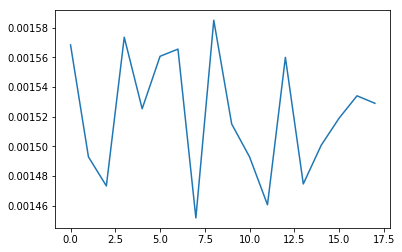

In [74]:
plt.plot(mean_error)
plt.show()

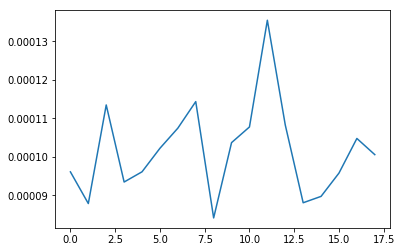

In [76]:
plt.plot(mean_error)
plt.show()

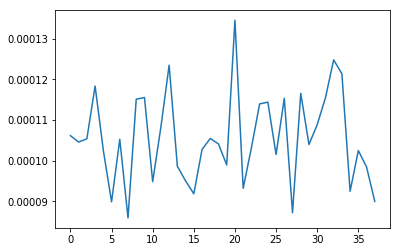

In [78]:
plt.plot(mean_error)
plt.show()

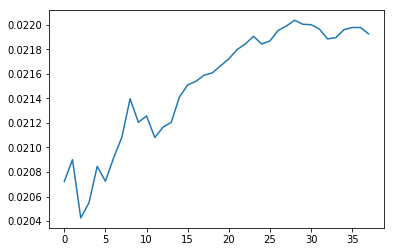

In [109]:
plt.plot(mean_error)
plt.show()

In [110]:
print('Random Forest Feature Weights')
for i in range(0, len(test[col_names].keys())): print(fit.coef_[i], test[col_names].keys()[i])

Random Forest Feature Weights
1.17657237965 prev_cpi
-0.537956887436 prev_ppi
0.0140606819503 prev_unemp
-1.63956606246 mean_cpi
2.1298739046 mean_ppi
0.189302158167 mean_unemp


In [86]:
test.keys()

Index(['prev_cpi', 'prev_ppi', 'prev_unemp', 'current_cpi', 'current_ppi',
       'current_unemp', 'mean_cpi', 'mean_ppi', 'mean_unemp'],
      dtype='object')

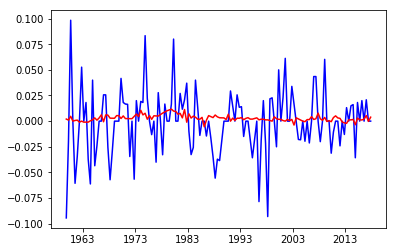

In [104]:
plt.plot(test['pd_date'],test['current_unemp'], 'b-', test['pd_date'], test['current_cpi'], 'r-')
plt.show()

In [9]:
small_bis=pd.read_excel('small_bus_optimism.xlsx')
small_bis['pd_date']=pd.to_datetime(small_bis['Month/Year'])
small_bis=small_bis[::-1]
small_bis=small_bis.reset_index()
small_bis=small_bis.drop(['index'], axis=1)

In [118]:
small_bis.head()

,Month/Year,Small Business Optimism,pd_date
0,1986/1/1,100.2850,1986-01-01
1,1986/2/1,99.7915,1986-02-01
2,1986/3/1,101.4630,1986-03-01
3,1986/4/1,101.0150,1986-04-01
4,1986/5/1,101.9560,1986-05-01


In [10]:
temp_combined_df = date_align(cpi_data, 'CPIAUCSL', small_bis, 'Small Business Optimism')
combined_df['small_bis_opt']=temp_combined_df['Small Business Optimism']
[sb_diff, sb_diff_perc]=create_diff_vector(combined_df, 'small_bis_opt', 'pd_date')
combined_df['sb_diff']=sb_diff
combined_df['sb_diff_perc']=sb_diff_perc

In [132]:
combined_df[468:475]

,pd_date,CPIAUCSL,UNRATE,cpi_diff,cpi_diff_perc,unemp_diff,unemp_diff_perc,PPI,ppi_diff,ppi_diff_perc,small_bis_opt,sb_diff,sb_diff_perc
468,1986-01-01,109.9,6.7,0.4,0.003640,-0.3,-0.044776,103.2,-0.4,-0.003876,100.2850,NaN,NaN
469,1986-02-01,109.7,7.2,-0.2,-0.001823,0.5,0.069444,101.7,-1.5,-0.014749,99.7915,-0.4935,-0.004945
470,1986-03-01,109.1,7.2,-0.6,-0.005500,0.0,0.000000,100.3,-1.4,-0.013958,101.4630,1.6715,0.016474
471,1986-04-01,108.7,7.1,-0.4,-0.003680,-0.1,-0.014085,99.6,-0.7,-0.007028,101.0150,-0.4480,-0.004435
472,1986-05-01,109.0,7.2,0.3,0.002752,0.1,0.013889,100.0,0.4,0.004000,101.9560,0.9410,0.009229
473,1986-06-01,109.4,7.2,0.4,0.003656,0.0,0.000000,99.9,-0.1,-0.001001,101.2890,-0.6670,-0.006585
474,1986-07-01,109.5,7.0,0.1,0.000913,-0.2,-0.028571,99.4,-0.5,-0.005030,99.8372,-1.4518,-0.014542


In [131]:
len(combined_df)

852

In [133]:
days_to_average=6

prev_cpi=[]
prev_ppi=[]
prev_unemp=[]
current_cpi=[]
current_ppi=[]
current_unemp=[]
cpi_mean=[]
ppi_mean=[]
unemp_mean=[]
dates=[]
prev_sbo=[]
curr_sbo=[]
mean_sbo=[]
#468 is Jan 1986
for i in range(480, len(combined_df['pd_date'])):
    prev_cpi.append(combined_df['cpi_diff_perc'][i-1])
    prev_ppi.append(combined_df['ppi_diff_perc'][i-1])
    prev_unemp.append(combined_df['unemp_diff_perc'][i-1])
    current_cpi.append(combined_df['cpi_diff_perc'][i])
    current_ppi.append(combined_df['ppi_diff_perc'][i])
    current_unemp.append(combined_df['unemp_diff_perc'][i])
    cpi_mean.append(np.nanmean(combined_df['cpi_diff_perc'][i-days_to_average:i-1]))
    ppi_mean.append(np.nanmean(combined_df['ppi_diff_perc'][i-days_to_average:i-1]))
    unemp_mean.append(np.nanmean(combined_df['unemp_diff_perc'][i-days_to_average:i-1]))
    prev_sbo.append(combined_df['sb_diff_perc'][i-1])
    curr_sbo.append(combined_df['sb_diff_perc'][i])
    mean_sbo.append(np.nanmean(combined_df['sb_diff_perc'][i-days_to_average:i-1]))
    dates.append(combined_df['pd_date'][i])
dataset=pd.DataFrame()
dataset['pd_date']=dates
dataset['prev_cpi']=prev_cpi
dataset['prev_ppi']=prev_ppi
dataset['prev_unemp']=prev_unemp
dataset['current_cpi']=current_cpi
dataset['current_ppi']=current_ppi
dataset['current_unemp']=current_unemp
dataset['mean_cpi']=cpi_mean
dataset['mean_ppi']=ppi_mean
dataset['mean_unemp']=unemp_mean
dataset['prev_sbo']=prev_sbo
dataset['curr_sbo']=curr_sbo
dataset['mean_sbo']=mean_sbo
final_values=dataset[-1:]
dataset=dataset[:-1]
temp=[dataset[1::5], dataset[2::5], dataset[3::5], dataset[4::5]]
training=pd.concat(temp)
test=dataset[5::5]

In [142]:
col_names=['prev_cpi', 'prev_ppi', 'prev_unemp', 'prev_sbo', 'mean_cpi', 'mean_ppi', 'mean_unemp', 'mean_sbo']

predicted_value='current_cpi'
model=LinearRegression()
#model=RandomForestRegressor()
fit=model.fit(training[col_names], training[predicted_value])
lr_prediction=fit.predict(test[col_names])
print('average error in prediction:')
print(np.mean(np.abs(lr_prediction-test[predicted_value])))
print('average std in prediction error:')
print(np.std(np.abs(lr_prediction-test[predicted_value])))
print('average predicted value:')
print(np.mean(np.abs(test[predicted_value])))

average error in prediction:
0.0015728625475010828
average std in prediction error:
0.0013993985994098955
average predicted value:
0.0023062337244023623


In [140]:
col_names=['prev_cpi', 'prev_ppi', 'prev_unemp', 'mean_cpi', 'mean_ppi', 'mean_unemp']

predicted_value='current_cpi'
model=LinearRegression()
#model=RandomForestRegressor()
fit=model.fit(training[col_names], training[predicted_value])
lr_prediction=fit.predict(test[col_names])
print('average error in prediction:')
print(np.mean(np.abs(lr_prediction-test[predicted_value])))
print('average std in prediction error:')
print(np.std(np.abs(lr_prediction-test[predicted_value])))
print('average predicted value:')
print(np.mean(np.abs(test[predicted_value])))

average error in prediction:
0.0015649149041613805
average std in prediction error:
0.0013948206399051258
average predicted value:
0.0023062337244023623


In [143]:
print('Linear Regression Feature Weights')
for i in range(0, len(test[col_names].keys())): print(fit.coef_[i], test[col_names].keys()[i])

Linear Regression Feature Weights
0.239742653089 prev_cpi
0.0837189250153 prev_ppi
0.006061045497 prev_unemp
0.00390563152834 prev_sbo
0.0766487090233 mean_cpi
-0.0452163393127 mean_ppi
-0.0198669131211 mean_unemp
-0.0280119577544 mean_sbo


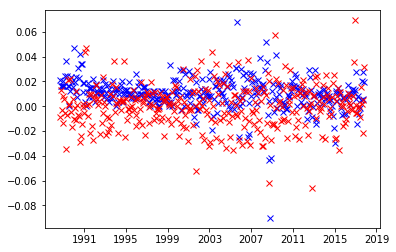

In [154]:
plt.plot(combined_df['pd_date'][500:-1], combined_df['cpi_diff_perc'][500:-1]*5, 'bx', combined_df['pd_date'][500:-1], combined_df['sb_diff_perc'][500:-1], 'rx')
plt.show()

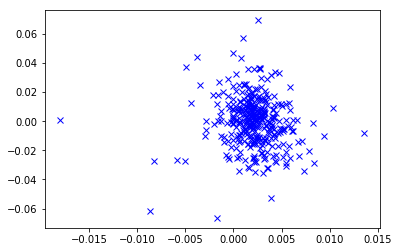

In [156]:
plt.plot(combined_df['cpi_diff_perc'][500:-1], combined_df['sb_diff_perc'][500:-1], 'bx')
plt.show()

In [231]:
oil_price=pd.read_csv('brent_crude_monthly_av_price.csv')

In [232]:
oil_price.columns=['Date', 'Price', 'Change']
oil_price=remove_rows(oil_price, 1)

In [216]:
oil_price[:20]

,Date,Price,Change,pd_date
0,Dec-1987,16.63,-,1987-12-01
1,Jan-1988,16.47,-0.96%,1988-01-01
2,Feb-1988,15.85,-3.76%,1988-02-01
3,Mar-1988,14.78,-6.75%,1988-03-01
4,Apr-1988,16.47,11.43%,1988-04-01
5,May-1988,16.22,-1.52%,1988-05-01
6,Jun-1988,15.33,-5.49%,1988-06-01
7,Jul-1988,14.48,-5.54%,1988-07-01
8,Aug-1988,14.55,0.48%,1988-08-01
9,Sep-1988,13.1,-9.97%,1988-09-01


In [233]:
for i in range(0, len(oil_price['Date'])):
    if int(oil_price['Date'][i][-2:])>75:
        oil_price['Date'][i]=oil_price['Date'][i][:-2]+'19'+oil_price['Date'][i][-2:]
    else:
        oil_price['Date'][i]=oil_price['Date'][i][:-2]+'20'+oil_price['Date'][i][-2:]

In [179]:
pd.to_datetime('Dec-2000')

Timestamp('2000-12-01 00:00:00')

In [207]:
if int(oil_price['Date'][0][-2:])>75:
    print()

True

In [193]:
oil_price['Date'][0][:-2]

'Dec-'

In [234]:
oil_price['pd_date']=pd.to_datetime(oil_price['Date'])

In [236]:
temp=[]
for i in range(0, len(oil_price['Date'])):
    temp.append(float(oil_price['Price'][i]))

In [235]:
float(oil_price['Price'][0])

16.63

In [225]:
float(oil_price['Price'][280])

116.24

In [240]:
oil_price['Price'][0:5]

0    16.63
1    16.47
2    15.85
3    14.78
4    16.47
Name: Price, dtype: float64

In [238]:
temp[0:5]

[16.63, 16.47, 15.85, 14.78, 16.47]

In [239]:
oil_price['Price']=temp

In [1]:
plt.plot(price_oil['pd_date'], price_oil['POILBREUSDM'])
plt.show()

NameError: name 'plt' is not defined

In [14]:
price_oil=pd.read_csv('POILBREUSDM.csv')
price_oil['pd_date']=pd.to_datetime(price_oil['DATE'])
temp_combined_df = date_align(cpi_data, 'CPIAUCSL', price_oil, 'POILBREUSDM')
combined_df['price_oil']=temp_combined_df['POILBREUSDM']
[price_oil_diff, price_oil_diff_perc]=create_diff_vector(combined_df, 'price_oil', 'pd_date')
combined_df['price_oil_diff']=price_oil_diff
combined_df['price_oil_diff_perc']=price_oil_diff_perc

In [243]:
poil.head()

,DATE,POILBREUSDM
0,1980-01-01,40.00
1,1980-02-01,38.50
2,1980-03-01,38.25
3,1980-04-01,38.15
4,1980-05-01,38.50


In [15]:
combined_df.head()

,pd_date,CPIAUCSL,UNRATE,cpi_diff,cpi_diff_perc,unemp_diff,unemp_diff_perc,PPI,ppi_diff,ppi_diff_perc,small_bis_opt,sb_diff,sb_diff_perc,price_oil,price_oil_diff,price_oil_diff_perc
0,1947-01-01,21.48,NaN,NaN,NaN,NaN,NaN,24.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1947-02-01,21.62,NaN,0.14,0.006475,NaN,NaN,24.7,0.2,0.008097,NaN,NaN,NaN,NaN,NaN,NaN
2,1947-03-01,22.00,NaN,0.38,0.017273,NaN,NaN,25.3,0.6,0.023715,NaN,NaN,NaN,NaN,NaN,NaN
3,1947-04-01,22.00,NaN,0.00,0.000000,NaN,NaN,25.1,-0.2,-0.007968,NaN,NaN,NaN,NaN,NaN,NaN
4,1947-05-01,21.95,NaN,-0.05,-0.002278,NaN,NaN,25.0,-0.1,-0.004000,NaN,NaN,NaN,NaN,NaN,NaN


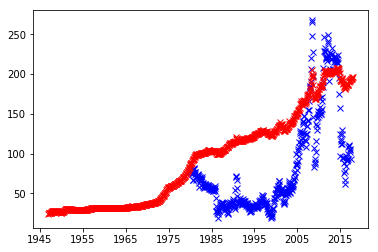

In [18]:
plt.plot(combined_df['pd_date'], combined_df['price_oil']*2, 'bx', combined_df['pd_date'], combined_df['PPI'], 'rx')
plt.show()

In [85]:
days_to_average=6
prev_cpi=[]
prev_ppi=[]
prev_unemp=[]
current_cpi=[]
current_ppi=[]
current_unemp=[]
cpi_mean=[]
ppi_mean=[]
unemp_mean=[]
dates=[]
prev_sbo=[]
curr_sbo=[]
mean_sbo=[]
prev_op=[]
curr_op=[]
op_mean=[]
#468 is Jan 1986, good for SBO
for i in range(480, len(combined_df['pd_date'])):
    prev_cpi.append(combined_df['cpi_diff_perc'][i-1])
    prev_ppi.append(combined_df['ppi_diff_perc'][i-1])
    prev_unemp.append(combined_df['unemp_diff_perc'][i-1])
    current_cpi.append(combined_df['cpi_diff_perc'][i])
    current_ppi.append(combined_df['ppi_diff_perc'][i])
    current_unemp.append(combined_df['unemp_diff_perc'][i])
    cpi_mean.append(np.nanmean(combined_df['cpi_diff_perc'][i-days_to_average:i-1]))
    ppi_mean.append(np.nanmean(combined_df['ppi_diff_perc'][i-days_to_average:i-1]))
    unemp_mean.append(np.nanmean(combined_df['unemp_diff_perc'][i-days_to_average:i-1]))
    prev_sbo.append(combined_df['sb_diff_perc'][i-1])
    curr_sbo.append(combined_df['sb_diff_perc'][i])
    mean_sbo.append(np.nanmean(combined_df['sb_diff_perc'][i-days_to_average:i-1]))
    dates.append(combined_df['pd_date'][i])
    prev_op.append(combined_df['price_oil_diff_perc'][i-1])
    curr_op.append(combined_df['price_oil_diff_perc'][i])
    op_mean.append(np.nanmean(combined_df['price_oil_diff_perc'][i-days_to_average:i-1]))
dataset=pd.DataFrame()
dataset['pd_date']=dates
dataset['prev_cpi']=prev_cpi
dataset['prev_ppi']=prev_ppi
dataset['prev_unemp']=prev_unemp
dataset['current_cpi']=current_cpi
dataset['current_ppi']=current_ppi
dataset['current_unemp']=current_unemp
dataset['mean_cpi']=cpi_mean
dataset['mean_ppi']=ppi_mean
dataset['mean_unemp']=unemp_mean
dataset['prev_sbo']=prev_sbo
dataset['curr_sbo']=curr_sbo
dataset['mean_sbo']=mean_sbo
dataset['prev_op']=prev_op
dataset['curr_op']=curr_op
dataset['op_mean']=op_mean
dataset=dataset[:-7]
temp=[dataset[1::5], dataset[2::5], dataset[3::5], dataset[4::5]]
training=pd.concat(temp)
test=dataset[5::5]

In [142]:
col_names=['prev_ppi', 'mean_ppi', 'curr_op', 'prev_op', 'op_mean', 'current_ppi', 'mean_cpi']

predicted_value='current_cpi'
model=LinearRegression()
#model=RandomForestRegressor()
fit=model.fit(training[col_names], training[predicted_value])
lr_prediction=fit.predict(test[col_names])
print('average error in prediction:')
print(np.mean(np.abs(lr_prediction-test[predicted_value])))
#print(np.mean(np.abs(lr_prediction-training[predicted_value])))
print('average std in prediction error:')
print(np.std(np.abs(lr_prediction-test[predicted_value])))
print('average predicted value:')
print(np.mean(np.abs(test[predicted_value])))

average error in prediction:
0.0011977611778637692
average std in prediction error:
0.001005285331640798
average predicted value:
0.002313646047609151


In [44]:
combined_df['price_oil'][-7:]

845    46.894545
846          NaN
847          NaN
848          NaN
849          NaN
850          NaN
851          NaN
Name: price_oil, dtype: float64

In [47]:
dataset[-5:]

,pd_date,prev_cpi,prev_ppi,prev_unemp,current_cpi,current_ppi,current_unemp,mean_cpi,mean_ppi,mean_unemp,prev_sbo,curr_sbo,mean_sbo,prev_op,curr_op,op_mean
360,2017-01-01,0.002562,0.010096,0.021277,0.005476,0.013110,0.020833,0.001954,-0.001395,-0.013125,0.069321,0.000690,0.007981,54.065455,54.892727,46.714445
361,2017-02-01,0.005476,0.013110,0.020833,0.001219,0.004697,-0.021277,0.002419,0.000518,-0.008870,0.000690,-0.005548,0.021632,54.892727,55.493500,48.513346
362,2017-03-01,0.001219,0.004697,-0.021277,-0.002888,-0.000522,-0.044444,0.003106,0.004318,-0.004703,-0.005548,-0.005857,0.022196,55.493500,51.968261,50.263022
363,2017-04-01,-0.002888,-0.000522,-0.044444,0.001663,0.007772,-0.022727,0.002838,0.004937,-0.012958,-0.005857,-0.001656,0.021766,51.968261,53.063500,52.123994
364,2017-05-01,0.001663,0.007772,-0.022727,-0.001279,-0.001037,-0.023256,0.001691,0.005047,-0.017766,-0.001656,0.000258,0.018882,53.063500,50.870870,52.571170


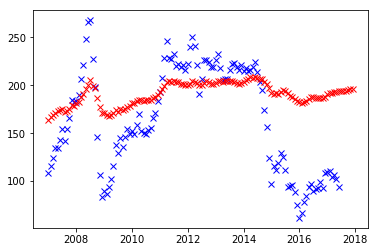

In [75]:
plt.plot(combined_df['pd_date'][720:], combined_df['price_oil'][720:]*2, 'bx', combined_df['pd_date'][720:], combined_df['PPI'][720:], 'rx')
plt.show()

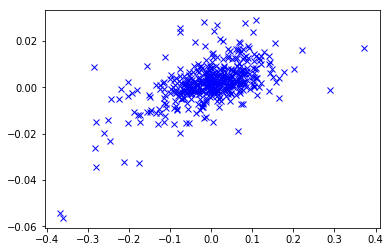

In [102]:
plt.plot(combined_df['price_oil_diff_perc'], combined_df['ppi_diff_perc'], 'bx')
plt.show()

In [100]:
combined_df.head()

,pd_date,CPIAUCSL,UNRATE,cpi_diff,cpi_diff_perc,unemp_diff,unemp_diff_perc,PPI,ppi_diff,ppi_diff_perc,small_bis_opt,sb_diff,sb_diff_perc,price_oil,price_oil_diff,price_oil_diff_perc
0,1947-01-01,21.48,NaN,NaN,NaN,NaN,NaN,24.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1947-02-01,21.62,NaN,0.14,0.006475,NaN,NaN,24.7,0.2,0.008097,NaN,NaN,NaN,NaN,NaN,NaN
2,1947-03-01,22.00,NaN,0.38,0.017273,NaN,NaN,25.3,0.6,0.023715,NaN,NaN,NaN,NaN,NaN,NaN
3,1947-04-01,22.00,NaN,0.00,0.000000,NaN,NaN,25.1,-0.2,-0.007968,NaN,NaN,NaN,NaN,NaN,NaN
4,1947-05-01,21.95,NaN,-0.05,-0.002278,NaN,NaN,25.0,-0.1,-0.004000,NaN,NaN,NaN,NaN,NaN,NaN


In [234]:
col_names=['prev_ppi', 'mean_ppi', 'curr_op', 'prev_op', 'mean_op', 'current_ppi', 'mean_cpi']

predicted_value='current_cpi'

batches=20


model=Sequential()
s='relu'
model.add(Dense(15, activation=s, input_dim=len(col_names)))
model.add(Dropout(.1))
model.add(Dense(15, activation=s))
model.add(Dropout(.1))
model.add(Dense(1, activation='linear'))
#keras.optimizers.RMSprop(lr=.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model.fit(training[col_names], training[predicted_value], batch_size=batches, epochs=500, verbose=0)

nn_prediction=model.predict(test[col_names])
nn_prediction=np.ndarray.tolist(nn_prediction)
nn_prediction=[float(nn_prediction[i][0]) for i in range(len(nn_prediction))]

print('average error in prediction:')
print(np.mean(np.abs(nn_prediction-test[predicted_value])))
#print(np.mean(np.abs(lr_prediction-training[predicted_value])))
print('average std in prediction error:')
print(np.std(np.abs(nn_prediction-test[predicted_value])))
print('average predicted value:')
print(np.mean(np.abs(test[predicted_value])))

average error in prediction:
0.001212451593731678
average std in prediction error:
0.0009173757205160885
average predicted value:
0.002313646047609151


In [130]:
nn_prediction[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [127]:
len(nn_prediction)

72

In [119]:
test[predicted_value].shape

(72,)

In [121]:
nn_prediction=np.ndarray.tolist(nn_prediction)

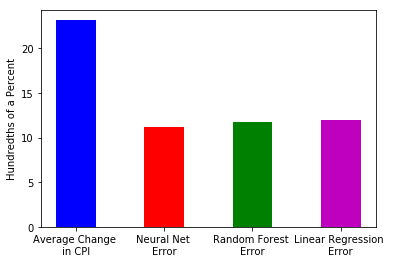

In [164]:
c1, c2, c3, c4 = plt.bar(np.arange(4), [23.1, 11.2, 11.79, 11.98], .45)
c1.set_facecolor('b')
c2.set_facecolor('r')
c3.set_facecolor('g')
c4.set_facecolor('m')
plt.xticks(np.arange(4), ('Average Change \nin CPI', 'Neural Net \nError', 'Random Forest \nError', 'Linear Regression \nError'))
plt.ylabel('Hundredths of a Percent')
plt.show()

In [165]:
ppi_idc=pd.read_csv('PPIIDC.csv')

In [166]:
ppi_idc.keys()

Index(['DATE', 'PPIIDC'], dtype='object')

In [168]:
ppi_idc['pd_date']=pd.to_datetime(ppi_idc['DATE'])

In [179]:
ppi_idc=remove_rows(ppi_idc, 420)

In [172]:
ppi_data=pd.read_csv('PPIACO.csv')
ppi_data['pd_date']=pd.to_datetime(ppi_data['DATE'])

In [180]:
ppi_idc.head()

,DATE,PPIIDC,pd_date
0,1948-01-01,24.3,1948-01-01
1,1948-02-01,24.1,1948-02-01
2,1948-03-01,24.1,1948-03-01
3,1948-04-01,24.3,1948-04-01
4,1948-05-01,24.3,1948-05-01


In [178]:
temp.head()

,DATE,PPIIDC,pd_date
0,1948-01-01,24.3,1948-01-01
1,1948-02-01,24.1,1948-02-01
2,1948-03-01,24.1,1948-03-01
3,1948-04-01,24.3,1948-04-01
4,1948-05-01,24.3,1948-05-01


In [181]:
temp_combined_df = date_align(cpi_data, 'CPIAUCSL', ppi_idc, 'PPIIDC')

In [182]:
combined_df['PPIIDC']=temp_combined_df['PPIIDC']

In [183]:
[ppiidc_diff, ppiidc_diff_perc]=create_diff_vector(combined_df, 'PPIIDC', 'pd_date')
combined_df['ppiidc_diff']=sb_diff
combined_df['ppiidc_diff_perc']=sb_diff_perc

In [184]:
combined_df.tail()

,pd_date,CPIAUCSL,UNRATE,cpi_diff,cpi_diff_perc,unemp_diff,unemp_diff_perc,PPI,ppi_diff,ppi_diff_perc,small_bis_opt,sb_diff,sb_diff_perc,price_oil,price_oil_diff,price_oil_diff_perc,PPIIDC,ppiidc_diff,ppiidc_diff_perc
847,2017-08-01,245.030,4.4,0.982,0.004008,0.1,0.022727,193.8,0.3,0.001548,105.388,0.183,0.001736,NaN,NaN,NaN,193.9,0.183,0.001736
848,2017-09-01,246.373,4.2,1.343,0.005451,-0.2,-0.047619,194.5,0.7,0.003599,103.196,-2.192,-0.021241,NaN,NaN,NaN,195.2,-2.192,-0.021241
849,2017-10-01,246.639,4.1,0.266,0.001078,-0.1,-0.024390,194.8,0.3,0.001540,103.744,0.548,0.005282,NaN,NaN,NaN,195.6,0.548,0.005282
850,2017-11-01,247.592,4.1,0.953,0.003849,0.0,0.000000,195.8,1.0,0.005107,107.123,3.379,0.031543,NaN,NaN,NaN,196.5,3.379,0.031543
851,2017-12-01,247.963,4.1,0.371,0.001496,0.0,0.000000,196.4,0.6,0.003055,104.475,-2.648,-0.025346,NaN,NaN,NaN,197.3,-2.648,-0.025346


In [190]:
pce=pd.read_csv('PCE.csv')

In [191]:
pce['pd_date']=pd.to_datetime(pce['DATE'])

In [192]:
pce.head()

,DATE,PCE,pd_date
0,1959-01-01,306.5,1959-01-01
1,1959-02-01,310.0,1959-02-01
2,1959-03-01,313.1,1959-03-01
3,1959-04-01,312.6,1959-04-01
4,1959-05-01,316.5,1959-05-01


In [193]:
temp_combined_df = date_align(cpi_data, 'CPIAUCSL', pce, 'PCE')

In [194]:
combined_df['PCE']=temp_combined_df['PCE']

In [197]:
[pce_diff, pce_diff_perc]=create_diff_vector(combined_df, 'PCE', 'pd_date')
combined_df['pce_diff']=pce_diff
combined_df['pce_diff_perc']=pce_diff_perc

In [198]:
combined_df.head()

,pd_date,CPIAUCSL,UNRATE,cpi_diff,cpi_diff_perc,unemp_diff,unemp_diff_perc,PPI,ppi_diff,ppi_diff_perc,...,price_oil,price_oil_diff,price_oil_diff_perc,PPIIDC,ppiidc_diff,ppiidc_diff_perc,PCE,pce,pce_diff,pce_diff_perc
0,1947-01-01,21.48,NaN,NaN,NaN,NaN,NaN,24.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1947-02-01,21.62,NaN,0.14,0.006475,NaN,NaN,24.7,0.2,0.008097,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1947-03-01,22.00,NaN,0.38,0.017273,NaN,NaN,25.3,0.6,0.023715,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1947-04-01,22.00,NaN,0.00,0.000000,NaN,NaN,25.1,-0.2,-0.007968,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1947-05-01,21.95,NaN,-0.05,-0.002278,NaN,NaN,25.0,-0.1,-0.004000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [251]:
days_to_average=6
prev_cpi=[]
prev_ppi=[]
prev_unemp=[]
current_cpi=[]
current_ppi=[]
current_unemp=[]
cpi_mean=[]
ppi_mean=[]
unemp_mean=[]
dates=[]
prev_sbo=[]
curr_sbo=[]
mean_sbo=[]
prev_op=[]
curr_op=[]
mean_op=[]
prev_ppi_idc=[]
curr_ppi_idc=[]
mean_ppi_idc=[]
prev_pce=[]
curr_pce=[]
mean_pce=[]
#468 is Jan 1986, good for SBO
for i in range(480, len(combined_df['pd_date'])):
    prev_cpi.append(combined_df['cpi_diff_perc'][i-1])
    prev_ppi.append(combined_df['ppi_diff_perc'][i-1])
    prev_unemp.append(combined_df['unemp_diff_perc'][i-1])
    current_cpi.append(combined_df['cpi_diff_perc'][i])
    current_ppi.append(combined_df['ppi_diff_perc'][i])
    current_unemp.append(combined_df['unemp_diff_perc'][i])
    cpi_mean.append(np.nanmean(combined_df['cpi_diff_perc'][i-days_to_average:i-1]))
    ppi_mean.append(np.nanmean(combined_df['ppi_diff_perc'][i-days_to_average:i-1]))
    unemp_mean.append(np.nanmean(combined_df['unemp_diff_perc'][i-days_to_average:i-1]))
    prev_sbo.append(combined_df['sb_diff_perc'][i-1])
    curr_sbo.append(combined_df['sb_diff_perc'][i])
    mean_sbo.append(np.nanmean(combined_df['sb_diff_perc'][i-days_to_average:i-1]))
    dates.append(combined_df['pd_date'][i])
    prev_op.append(combined_df['price_oil_diff_perc'][i-1])
    curr_op.append(combined_df['price_oil_diff_perc'][i])
    mean_op.append(np.nanmean(combined_df['price_oil_diff_perc'][i-days_to_average:i-1]))
    prev_ppi_idc.append(combined_df['ppiidc_diff_perc'][i-1])
    curr_ppi_idc.append(combined_df['ppiidc_diff_perc'][i])
    mean_ppi_idc.append(np.nanmean(combined_df['ppiidc_diff_perc'][i-days_to_average:i-1]))
    prev_pce.append(combined_df['pce_diff_perc'][i-1])
    curr_pce.append(combined_df['pce_diff_perc'][i])
    mean_pce.append(np.nanmean(combined_df['pce_diff_perc'][i-days_to_average:i-1]))
dataset=pd.DataFrame()
dataset['pd_date']=dates
dataset['prev_cpi']=prev_cpi
dataset['prev_ppi']=prev_ppi
dataset['prev_unemp']=prev_unemp
dataset['current_cpi']=current_cpi
dataset['current_ppi']=current_ppi
dataset['current_unemp']=current_unemp
dataset['mean_cpi']=cpi_mean
dataset['mean_ppi']=ppi_mean
dataset['mean_unemp']=unemp_mean
dataset['prev_sbo']=prev_sbo
dataset['curr_sbo']=curr_sbo
dataset['mean_sbo']=mean_sbo
dataset['prev_op']=prev_op
dataset['curr_op']=curr_op
dataset['mean_op']=mean_op
dataset['prev_ppi_idc']=prev_ppi_idc
dataset['curr_ppi_idc']=curr_ppi_idc
dataset['mean_ppi_idc']=mean_ppi_idc
dataset['prev_pce']=prev_pce
dataset['curr_pce']=curr_pce
dataset['mean_pce']=mean_pce
dataset=dataset[:-7]
temp=[dataset[1::5], dataset[2::5], dataset[3::5], dataset[4::5]]
training=pd.concat(temp)
test=dataset[5::5]

In [257]:
#col_names=['prev_cpi', 'mean_cpi', 'prev_ppi', 'mean_ppi', 'current_ppi', 'prev_unemp', 'mean_unemp', 'current_unemp', \
#           'prev_op', 'curr_op', 'mean_op', 'prev_ppi_idc', 'curr_ppi_idc', 'mean_ppi_idc', 'prev_pce', 'curr_pce', 'mean_pce']

col_names=['prev_cpi', 'mean_cpi', 'prev_ppi', 'mean_ppi', 'current_ppi', 'prev_unemp', 'current_unemp', \
           'prev_op', 'curr_op', 'prev_ppi_idc', 'curr_ppi_idc', 'mean_ppi_idc', 'prev_pce', 'curr_pce', 'mean_pce']




predicted_value='current_cpi'
#model=LinearRegression()
model=RandomForestRegressor()
fit=model.fit(training[col_names], training[predicted_value])
lr_prediction=fit.predict(test[col_names])
print('average error in prediction:')
print(np.mean(np.abs(lr_prediction-test[predicted_value])))

print('average predicted value:')
print(np.mean(np.abs(test[predicted_value])))

print('Linear Regression Feature Weights')
#for i in range(0, len(test[col_names].keys())): print(fit.coef_[i], test[col_names].keys()[i])
for i in range(0, len(test[col_names].keys())): print(fit.feature_importances_[i], test[col_names].keys()[i])

average error in prediction:
0.0011564188348248917
average predicted value:
0.002313646047609151
Linear Regression Feature Weights
0.0734090487045 prev_cpi
0.0323237230332 mean_cpi
0.0171150409026 prev_ppi
0.0163672250004 mean_ppi
0.562794927979 current_ppi
0.0207845492449 prev_unemp
0.0277349573677 current_unemp
0.0289538004093 prev_op
0.0450010309164 curr_op
0.0244586312403 prev_ppi_idc
0.0259268200744 curr_ppi_idc
0.0367174239022 mean_ppi_idc
0.0325196961002 prev_pce
0.0426430954696 curr_pce
0.0132500296552 mean_pce


In [208]:
test[predicted_value].keys()

RangeIndex(start=5, stop=365, step=5)

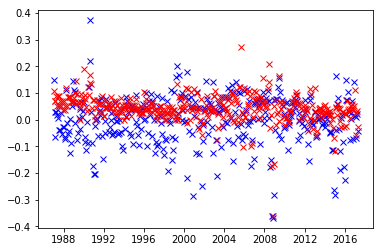

In [221]:
plt.plot(dataset['pd_date'], dataset['curr_op'], 'bx', dataset['pd_date'], dataset['current_cpi']*20, 'rx')
plt.show()

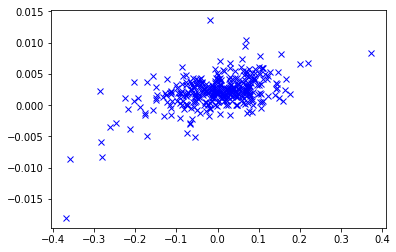

In [223]:
plt.plot(dataset['curr_op'], dataset['current_cpi'], 'bx')
plt.show()

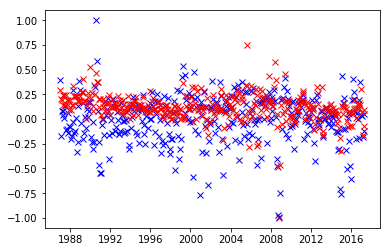

In [225]:
plt.plot(dataset['pd_date'], dataset['curr_op']/np.max(np.abs(dataset['curr_op'])), 'bx', dataset['pd_date'], dataset['current_cpi']/np.max(np.abs(dataset['current_cpi'])), 'rx')
plt.show()

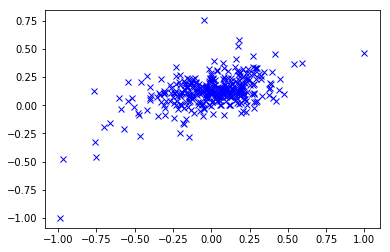

In [227]:
plt.plot(dataset['curr_op']/np.max(np.abs(dataset['curr_op'])), dataset['current_cpi']/np.max(np.abs(dataset['current_cpi'])), 'bx')
plt.show()

In [259]:
col_names=['prev_cpi', 'mean_cpi', 'prev_ppi', 'mean_ppi', 'current_ppi', 'prev_unemp', 'mean_unemp', 'current_unemp', \
           'prev_op', 'curr_op', 'mean_op', 'prev_ppi_idc', 'curr_ppi_idc', 'mean_ppi_idc', 'prev_pce', 'curr_pce', 'mean_pce']

predicted_value='current_cpi'

batches=20


model=Sequential()
s='relu'
model.add(Dense(30, activation=s, input_dim=len(col_names)))
model.add(Dropout(.1))
model.add(Dense(30, activation=s))
model.add(Dropout(.1))
model.add(Dense(1, activation='linear'))
#keras.optimizers.RMSprop(lr=.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model.fit(training[col_names], training[predicted_value], batch_size=batches, epochs=500, verbose=0)

nn_prediction=model.predict(test[col_names])
nn_prediction=np.ndarray.tolist(nn_prediction)
nn_prediction=[float(nn_prediction[i][0]) for i in range(len(nn_prediction))]

print('average error in prediction:')
print(np.mean(np.abs(nn_prediction-test[predicted_value])))

print('average predicted value:')
print(np.mean(np.abs(test[predicted_value])))

average error in prediction:
0.0013467818185072169
average predicted value:
0.002313646047609151
